# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

# Section 0: Initial data exploration

## 0.1 Loading the data
Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple function to load in text files containing the transcripts, figure out who the speakers are, and separate the text blocks into a list of words.

In [54]:
# Importing the libraries I'll be using
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mysql.connector
import re
from sklearn.preprocessing import QuantileTransformer
import time
import matplotlib.cm as cm

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}
plt.rc('font', **font)

In [7]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [8]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

Let's go ahead and pull all of the transcripts from the database - this dataset happens to be small enough that I can load it all at once.

I also divide the transcripts randomly into testing, training, and validation sets. This will ensure that when I perform analyses, I don't build models that over-fit the data.

In [9]:
num_transcripts = 4131
transcript_df = pull_transcript(n=num_transcripts)

# split the tables into testing and training sets, so that we don't over-fit. 
np.random.seed(42) # Ensures that the split is the same each round
transcript_df['train'] = np.random.rand(num_transcripts)>.2

# divide into two data structures
test_transcript_df = transcript_df.loc[transcript_df.train==False,:]
train_transcript_df = transcript_df.loc[transcript_df.train,:]

# Further separate the training dataset into a training and validation set
train_transcript_df.loc[:,'val'] = np.random.rand(train_transcript_df.shape[0])>.8
val_transcript_df = train_transcript_df.loc[train_transcript_df.val,:]
train_transcript_df = train_transcript_df.loc[train_transcript_df.val==False,:]

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 0.2 Example transcript

To understand the data, it helps to first see what the raw data looks like. Let's print a little bit of the transcript from the first dataset.

In [10]:
print(train_transcript_df.loc[1,'transcript'][:500])


    
        
    

    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).
    (LAUGHTER)
    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.
    PETER SAGAL, HOST: 
    Thank you, Bill. Thank you, everybody.
    (CHEERING)
    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to M


In [11]:
train_transcript_df.loc[1,'transcript'][:1000]

"\n    \n        \n    \n\n    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).\n    (LAUGHTER)\n    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.\n    PETER SAGAL, HOST: \n    Thank you, Bill. Thank you, everybody.\n    (CHEERING)\n    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to Microsoft co-founder Steve Ballmer. He is, we believe, the richest guest we've ever had. But, of course, your true wealth is measured in your friends. And this just in - he has more friends, too.\n    (LAUGHTER)\n    SAGAL: But first, as many of you know, the NPR podcast feeds got all screwed up last week. People who tried to download our show got, for example, How I Built This instead, for which I apologize. And the people who wanted How I Built This got us, for which I apologize eve

Initially, we can note a number of features. First, audience responses are noted with the '(LAUGHTER)' marker and '(APPLAUSE)' marker. This will prove very useful, as we have an automatic metric for "funniness" of the preceding text. 

Speakers' names are in all caps, followed by a colon. Speakers are also separated by a line break and a tab, which could potentially be used to segment the text into phrases by various people. 

## 0.3 Pre-processing the lines

I'm going to further split all of the transcripts, to divide them into individual lines. I can then label the lines by speaker, by whether they elicited applause or laughter, and mark the length of the line.

In [116]:
def line_info(transcript_numbers):
    
    # extract the transcript, and divide it by lines
    transcript = transcript_df.loc[transcript_numbers,'transcript'].str.cat();
    by_lines = transcript.split('\n    ')
    df = pd.DataFrame(by_lines,columns=['lines']) # turn the lines into a dataframe
    
    # if the line contains "LAUGHTER", mark the previous line as "funny"
    df['funny'] = df['lines'].str.contains('LAUGHTER')
    df['funny'] = df.funny.shift(-1) # need funny to modify the previous line
    
    # if the line contains "APPLAUSE", mark the previous line as "clapping"
    df['clapping'] = df['lines'].str.contains('APPLAUSE')
    df['clapping'] = df['lines'].str.contains('CLAPPING')
    df['clapping'] = df['lines'].str.contains('CHEERING')
    df['clapping'] = df.clapping.shift(-1)

    # for the remaining lines, identify the speaker using regular expressions
    df['speaker'] = df['lines'].str.extract(r'([A-Z]+:)',expand=False).str.replace(r':','')
    df['lines'] = df['lines'].str.replace(r'.+?(?=:)','').str.replace(r':','')
    df['speaker'] = df['speaker'].str.replace('JR','BLOUNT') # disambiguating Roy Blount Jr
    df['speaker'] = df['speaker'].str.replace('HOST','SAGAL') # sometimes refers to Sagal as host
    # NOTE: There's some weird formatting with Peter Sagal's first line, 
    # where it calls him "Host" and puts his statement on the next line. It's not a huge thing,
    # so I'm leaving it for now, but might be worth coming back to later.
    
    # drop the lines with no speaker (Applause markers, empty lines, etc.)
    df = df.dropna()
    
    # Create a column with the number of separated words
    df['num_words'] = df.lines.str.split().str.len()
    
    # Normalize the number of words with a quantile transformer
    QT = QuantileTransformer(n_quantiles=1000,output_distribution='uniform')
    QT.fit(df.num_words.values.reshape(-1,1)) 
    df['uniform_words'] = QT.transform(df.num_words.values.reshape(-1,1))
    
    # Create a column with whether the previous line was funny (for predictions)
    df['prev_line_funny'] = df.funny.shift(1)

    return df

# Wrapper for line-info, that enables me to add in the transcript ID that each line came from
# Note: This takes MUCH LONGER to calculate - the for loop structure fails to take advantage of a number
# of dataframe operations that are more optimized when running on lots of data.
# If you don't care about transcript IDs, then use line_info instead. 
# There might be a non-looped way to get out the transcript ID and segments; but for now this is working well enough.
def lines_plus_ID(transcript_numbers):
    partial_df = []
    for i,t in enumerate(transcript_numbers):
        partial_df.append(line_info([t]))
        partial_df[i].loc[:,'transcript_id'] = t # Which transcript did this line come from
        partial_df[i].loc[:,'segment'] = transcript_df.loc[t,'segment'] # Which segment did this line come from
    # Join the single-transcript dataframes together
    full_df =  pd.concat(partial_df)
    return full_df

In [119]:
# Process the training set and show the top of the dataframe
lines_df = lines_plus_ID(train_transcript_df.index)
full_lines_df = lines_plus_ID(transcript_df.index)
val_lines_df = lines_plus_ID(val_transcript_df.index)
lines_df.head()

,lines,funny,clapping,speaker,num_words,uniform_words,prev_line_funny,transcript_id,segment
4,"From NPR and WBEZ Chicago, this is WAIT WAIT....",True,False,KURTIS,25,8.283872e-01,NaN,1,who
6,I'm Bill Kurtis. And here's your host at the ...,False,False,KURTIS,17,7.656250e-01,True,1,who
7,,False,False,SAGAL,0,1.000000e-07,False,1,who
10,Thank you so much. We have a very interesting...,True,False,SAGAL,56,9.609375e-01,False,1,who
12,"But first, as many of you know, the NPR podca...",True,False,SAGAL,53,9.456445e-01,True,1,who


## 0.4 Line-wise analyses

I'm going to look at a few of the lines, to extract some early features of the data. 

### 0.4.1 Humor by segment
In this sub-section, I examine which segments tend to be the funniest and least-funny. 

,count,mean,std,min,25%,50%,75%,max,stderr
segment,,,,,,,,,
predictions,2795.0,0.276208,0.447201,0.0,0.0,0.0,1.0,1.0,0.008459
panel,26367.0,0.256798,0.436875,0.0,0.0,0.0,1.0,1.0,0.002690
who,30547.0,0.255410,0.436098,0.0,0.0,0.0,1.0,1.0,0.002495
bluff,13581.0,0.245269,0.430262,0.0,0.0,0.0,0.0,1.0,0.003692
job,53598.0,0.205567,0.404119,0.0,0.0,0.0,0.0,1.0,0.001746
limerick,16258.0,0.195842,0.396860,0.0,0.0,0.0,0.0,1.0,0.003112
lightning,27056.0,0.118680,0.323417,0.0,0.0,0.0,0.0,1.0,0.001966


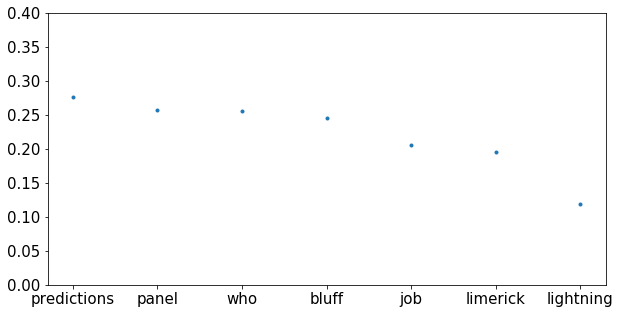

In [159]:
segment_humor = lines_df['funny'].astype('int').groupby(lines_df['segment']).describe().sort_values('mean',ascending=False)
segment_humor.loc[:,'stderr'] = segment_humor.loc[:,'std']/np.sqrt(segment_humor.loc[:,'count'])
plt.figure(figsize=(10,5))
plt.plot(segment_humor.loc[:,'mean'],'.')
plt.ylim([0,.4])
segment_humor

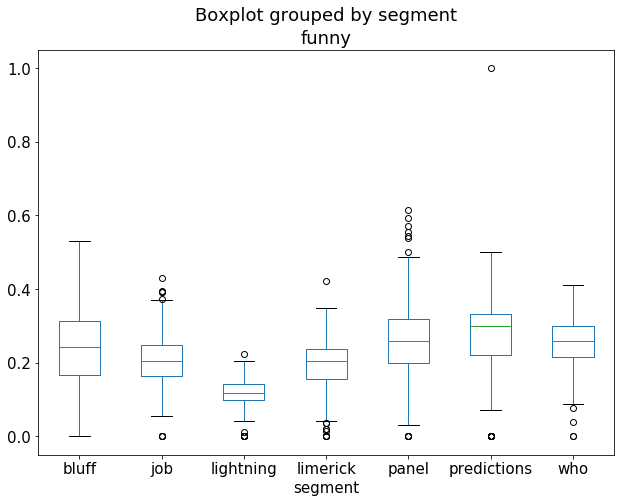

In [224]:
# Turns out to be easier to get info on funniness if it is treated as a number instead of a boolean
lines_df['funny'] = lines_df['funny'].astype('int')

# Get the mean funniness of each segment, preserving the segment id
funny_by_seg = lines_df.groupby(['segment','transcript_id']).mean()

# We can plot the funniness of each segment using a boxplot to indicate the distribution across segments
ax = pd.plotting.boxplot(funny_by_seg,column='funny',by='segment',figsize=(10,7.5),grid=False)

I'm going to plot the distribution of line lengths, and show how laughter and applause are distributed over the first set of lines.

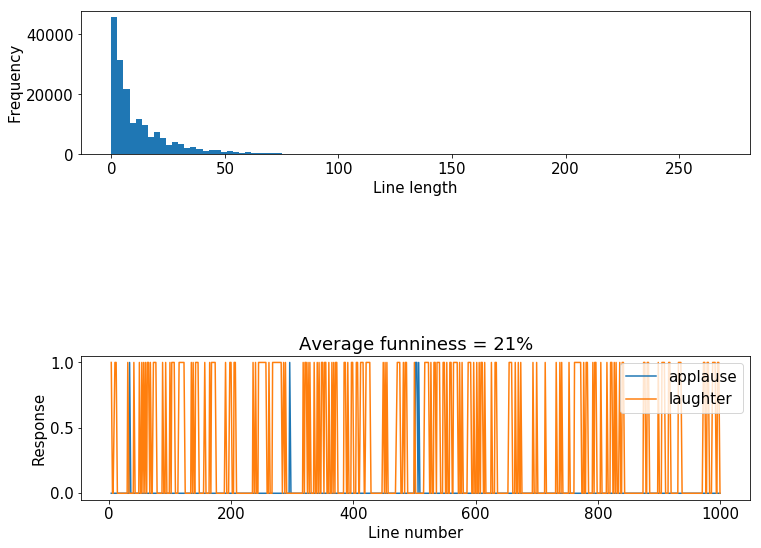

In [25]:
plt.figure(figsize=(12,9))
plt.subplot(3,1,1);
plt.hist(lines_df.num_words,bins=100);
plt.xlabel('Line length')
plt.ylabel('Frequency')



plt.subplot(3,1,3);
plt.plot(lines_df.loc[:1000,:].clapping)
plt.plot(lines_df.loc[:1000,:].funny);
plt.title(f'Average funniness = {int(np.mean(lines_df.funny)*100)}%')
plt.xlabel('Line number')
plt.ylabel('Response')
plt.legend(['applause','laughter'],loc='upper right')

length_vs_funny = np.corrcoef(lines_df.num_words.values,y=lines_df.funny.values.astype('float'))[1,0]
print(f'Correlation between line length and funniness is {length_vs_funny}')

So, now I have the data in a format which is going to be much easier to analyze. Furthermore, I know a few early descriptive statistics about the data:
1. Frequency of line lengths shows a nice, exponential decay.
2. 21% of the lines are funny
3. Longer lines have a slightly higher chance of being funny (correlation is .2)
4. The funniest segment is Panelist Predictions, while the least funny is the Lightning round

## 0.4 Word cloud
Just for fun, let's make a "word cloud" - this is a visualization tool that makes a pretty picture, with word sizes based on their frequency in the text. I based the formatting on this on the excellent tutorial by Max Woolf, posted [here](https://minimaxir.com/2016/05/wordclouds/). I'll make the picture in shades of orange, and in the shape of an exclamation point, in line with the logo of Wait Wait.

In [44]:
from wordcloud import WordCloud, STOPWORDS
import string
from palettable.colorbrewer.sequential import Oranges_9
import random
from PIL import Image

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Oranges_9.colors[random.randint(3,8)])

font_path = './Fonts/AmaticSC-Bold.ttf' # font from google fonts: https://fonts.google.com/?selection.family=AmaticSC

In [45]:
# concatenate the text from all of the transcripts
text = train_transcript_df.transcript.str.cat()

# convert everything to upper case so we don't get repeat counts
text = text.upper()

# remove the footer text at the bottom of each transcript
copyright_text = text[-475:]
stopwords = set(STOPWORDS)
stopwords = stopwords.union(set(copyright_text.split()))

In [47]:
# load the image mask: exclamation inside a circle from fontawesome
icon_path = './images/exclamation-sign.png'
icon = Image.open(icon_path)
icon = np.array(icon)

In [48]:
# generate the word cloud
wc = WordCloud(background_color="white", 
               font_path=font_path,
               collocations=False,
               max_words=1000,
               max_font_size=240, 
               random_state=42,
               mask=icon,
               stopwords=stopwords,
               color_func=color_func)
               
# generate word cloud
wc.generate_from_text(text.upper());

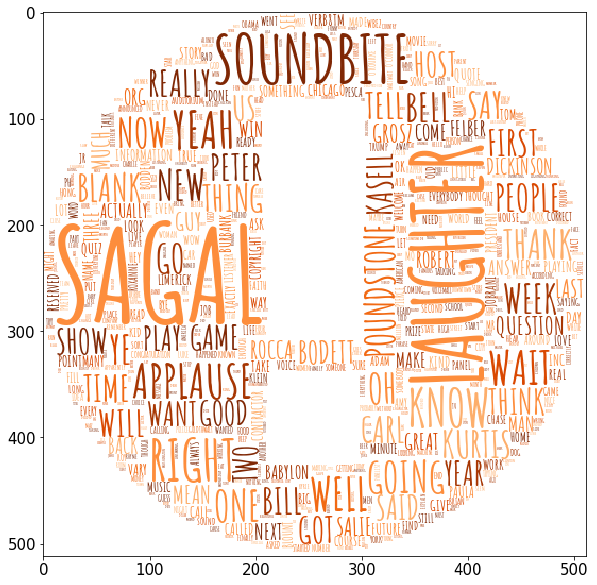

In [49]:
# plot the cloud
plt.figure(figsize=(10,10));
plt.imshow(wc);

# uncomment this to save the image
# wc.to_file("./images/WaitWaitCloud-big.png");

# 1 Analyzing Panelists

## 1.0 Panelists vs time

I want to analyze how the group of panelists on the show has changed over the years. To do so, I'm going to see how many shows each panelist did on each year, and then plot the distribution as it changes over time. We should be able to see old panelists fading out and new panelists being added in, as the years progress.

In [51]:
# Use the segment "Predictions" to get the panelists, as this segment typically does not involve guests or call-ins
predictions_df = transcript_df.loc[transcript_df.segment=='predictions'] # Get speaker info for 

# Separate the year from the airdate
years = pd.to_datetime(predictions_df['aired_at']).dt.year
predictions_df.loc[:,'year'] = years

# from the transcripts, extract the unique speakers, 
# representing the host (typically Sagal), scorekeeper (Kassel/Curtis) and panelists
speakers = predictions_df.transcript.str.extractall(r'([A-Z]+:)') # Caps followed by ":" denotes a speaker
speakers.iloc[:,0] = speakers.iloc[:,0].str.replace(r':','') # remove trailing colon
speakers.iloc[:,0] = speakers.iloc[:,0].str.replace(r'JR','BLOUNT') # correcting error with roy blount, jr.
unique_speakers = speakers.groupby('id').apply(np.unique) # find the unique names
unique_speakers = pd.DataFrame(unique_speakers,columns=['unique_speakers']) # make into a dataframe

# Add unique speakers to the predictions database
speakers_by_year_df = unique_speakers.join(predictions_df.loc[:,['year']]) 

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
# For each year, count the number of episodes each panelist was in
for i, year in enumerate(np.unique(speakers_by_year_df.year.values)):
    speaker_list = np.concatenate(speakers_by_year_df.loc[speakers_by_year_df.year==year,'unique_speakers'].values)
    counts = np.array(np.unique(speaker_list,return_counts=True)).T
    if i ==0: # initialize the dataframe on the first year
        count_df = pd.DataFrame(data = counts[:,1],index=counts[:,0],columns=[str(year)])
    else:
        count_df = count_df.join(pd.DataFrame(data = counts[:,1],index=counts[:,0],columns=[str(year)]),how='outer')

# If a speaker didn't appear in a given year, then give that entry a zero
count_df.fillna(0,inplace=True)

# Remove the years where we don't have all of the transcripts
count_df.drop(['2010','2019'],axis=1,inplace=True)

# Remove speakers who appear very rarely
count_df.drop(count_df.index[count_df.sum(axis=1)<=5],inplace=True)

# Remove non-panelists 
count_df.drop(['HOST','SAGAL','PESCA','KURTIS','KASELL','BYLINE','O'],inplace=True)
# count_df.drop(['HOST','BYLINE','O'],inplace=True)


# order the count by when the speaker's biggest number is
count_df.loc[:,'best_year'] = np.argmax(count_df.values/np.sum(count_df.values,axis=0),axis=1)
count_df.sort_values('best_year',inplace=True,ascending=True)
count_df.drop(['best_year'],axis=1,inplace=True)


# Show the counts
count_df

,2011,2012,2013,2014,2015,2016,2017,2018
BLOUNT,11,4,2,1,0,2,5,2
POUNDSTONE,16,13,12,13,13,12,12,12
BODETT,13,12,13,12,11,10,11,5
PIERCE,10,9,8,6,3,0,0,0
BABYLON,8,14,11,10,8,3,2,3
KLEIN,3,6,3,4,1,1,1,2
CONNOR,3,11,13,9,1,0,0,0
GOLDTHWAIT,0,2,5,2,1,4,0,1
FELBER,7,6,7,9,8,8,6,7
FERO,0,0,0,5,0,2,0,0


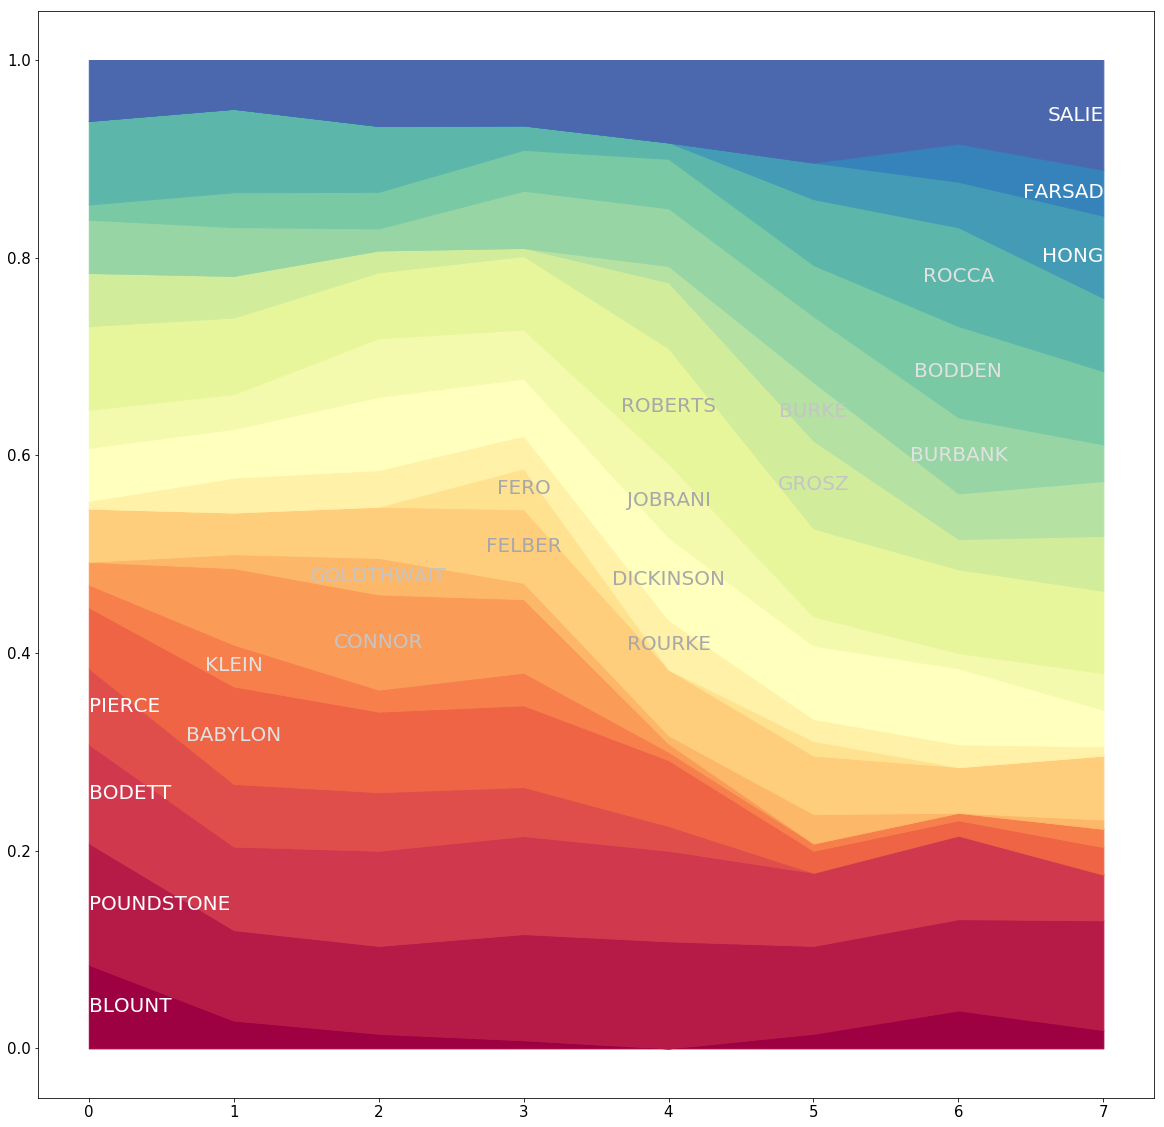

In [55]:

# Normalize count by the number of total panelists per year
frequencies = np.cumsum(count_df)/np.sum(count_df)

plt.figure(figsize=(20,20))

# Initialize some stuff for plotting the labels
colormap = cm.Spectral
txt_x = 0.5
stepsize = 6/frequencies.shape[0]
text_color = [.8,.8,.8]

# Fill in the first entry manually
plt.fill_between(range(8),frequencies.iloc[0,:],color=colormap(0))
txt_x = 0
txt_y = frequencies.iloc[0,txt_x]/2 #hacky
text_color = np.array([1, 1, 1])
label = frequencies.index[0]
plt.text(txt_x,txt_y,label,ha='left',va='center',color=text_color,fontsize=20)

# Loop through the remaining entries
for i in range(frequencies.shape[0]-1):
    t = plt.fill_between(range(8),frequencies.iloc[i,:],frequencies.iloc[i+1,:],color=colormap((i+1)/frequencies.shape[0]))
    
    # label the speaker
    txt_x = np.argmax(frequencies.iloc[i+1,:].values-frequencies.iloc[i,:].values)
    txt_y =np.mean(frequencies.iloc[[i,i+1],txt_x])
    text_color = ((np.abs(3.5-txt_x))-.5)/9+.66*np.array([1, 1, 1]) # shift text color so it shows up
    label = frequencies.index[i+1]
    if txt_x==0:
        plt.text(txt_x,txt_y,label,ha='left',va='center',color=text_color,fontsize=20)
    elif txt_x==7:
        plt.text(txt_x,txt_y,label,ha='right',va='center',color=text_color,fontsize=20)
    else:
        plt.text(txt_x,txt_y,label,ha='center',va='center',color=text_color,fontsize=20)

# uncomment this to save the image
plt.savefig('Panelists_vs_time.png', dpi=None, facecolor='None', edgecolor='None',
              orientation='portrait', format='png',
              transparent=True, bbox_inches=0, pad_inches=0,
              frameon=None)

## 1.1 Who is the funniest panelist? 

The first question I address is which panelist is the funniest. I'm aided in this process by the fact that laughter is marked in the transcripts, with the label "(LAUGHTER)". Thus, I can look at every laugh, and figure out who caused it. But people who talk more are likely to get more laughs than those who don't talk much, on average. So, I will calculate the "**Laugh rate**," defined as the number of laughs each speaker gets per statement. It can also be the probability of laughter, given something the panelist said. I will save my results in a pandas table.

In [232]:
panelist_humor = lines_df['funny'].groupby(lines_df['speaker'])
panelist_humor = panelist_humor.describe()

# Remove speakers that we didn't select in the previous section (one-off guests, call ins, and rare panelists)
panelist_humor = panelist_humor.loc[count_df.index,:] 
panelist_humor.sort_values('mean',ascending=False,inplace=True)

In [233]:
panelist_humor

,count,mean,std,min,25%,50%,75%,max
GOLDTHWAIT,782.0,0.387468,0.487484,0.0,0.0,0.0,1.0,1.0
BURKE,739.0,0.305819,0.461065,0.0,0.0,0.0,1.0,1.0
POUNDSTONE,6487.0,0.299522,0.458084,0.0,0.0,0.0,1.0,1.0
BODDEN,1655.0,0.278550,0.448421,0.0,0.0,0.0,1.0,1.0
BLOUNT,1127.0,0.270630,0.444483,0.0,0.0,0.0,1.0,1.0
BURBANK,2223.0,0.268556,0.443308,0.0,0.0,0.0,1.0,1.0
KLEIN,1141.0,0.263804,0.440887,0.0,0.0,0.0,1.0,1.0
FARSAD,445.0,0.258427,0.438263,0.0,0.0,0.0,1.0,1.0
ROCCA,3305.0,0.244781,0.430022,0.0,0.0,0.0,0.0,1.0
JOBRANI,1640.0,0.242073,0.428469,0.0,0.0,0.0,0.0,1.0


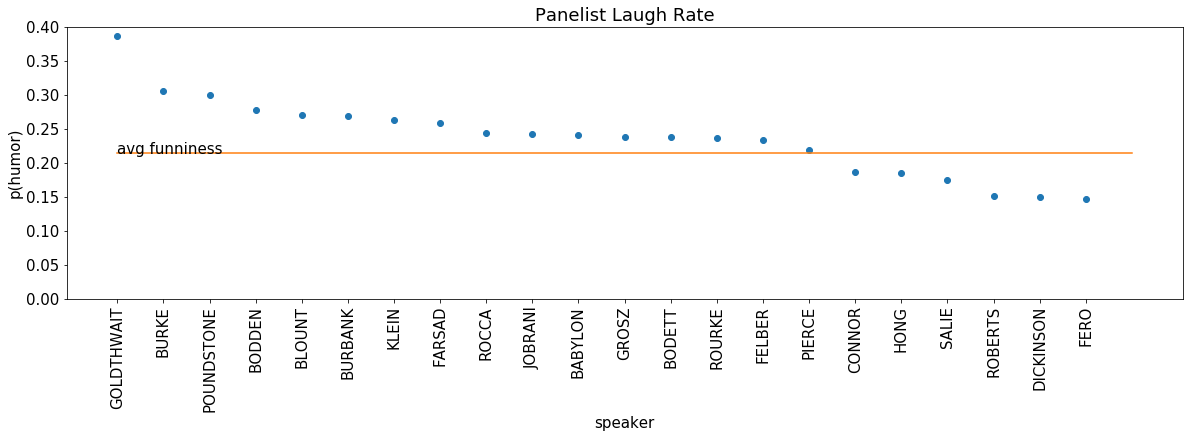

In [234]:
plt.figure(figsize=(20,5));
mean_funniness = lines_df['funny'].astype('int').mean() # average laugh rate over all panelists
plt.plot(panelist_humor.loc[:,'mean'],'o');
plt.plot([0, panelist_humor.shape[0]],[mean_funniness,mean_funniness]) # average line funniness
plt.text(0,mean_funniness,'avg funniness')

plt.xlabel('speaker');
plt.xticks(rotation=90);
plt.ylabel('p(humor)');
plt.ylim([0, .4]);
plt.title('Panelist Laugh Rate');
plt.savefig('Panelist_laugh_rate.svg',dpi=150)

There are some clear trends here. First, the top three panelists in terms of laugh rate are Bobcat Goldthwait, Adam Burke, and Paula Poundstone. The bottom panelists, in terms of laughs per line, are Amy Dickinson and Roxanne Roberts. In general, it looks like the distribution goes about as expected, with the panelists who are commedians coming out ahead of the panelists who are journalists in terms of funniness. 

However, I suspect that there are a few confounding factors, here. First of all, there is probably at least some "regression to the mean" - panelists with fewer lines total will tend to have a wider distribution than those with more lines. So for panelists with fewer lines, we should have less confidence overall in these measures. Indeed, if we plot the values below, we can see that of the top three funniest speakers, Goldthwait and Burke both have relatively few lines, which should perhaps give us less confidence in those metrics.

A better way of determining funniness for the future might be to sample funniness by transcript rather than across all lines and all times - this might let us better estimate the distribution of funniness of the panelists, and get a better sense of how reliable these measures are.

Text(0,0.5,'Laughs per line')

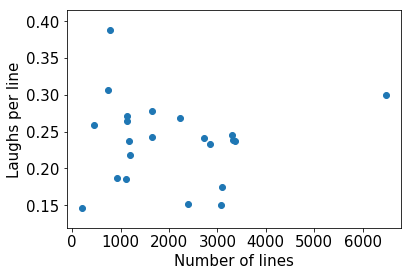

In [178]:
plt.scatter(panelist_humor.loc[:,'count'],panelist_humor.loc[:,'mean'])
plt.xlabel('Number of lines')
plt.ylabel('Laughs per line')

## 1.2 Panelist word frequencies
TF-IDF (Term Frequency-inverse document frequency) is a technique from natural language processing in which the frequency of words is compared between different "documents" (or blocks of text). Words are considered important for a given document if they occur much more frequently compared with the others.

I will apply this method to blocks of text from all panelists, to see if there are topics or words that are more common for some panelists than others.

In [48]:
# Join together all lines said by each panelist
for speaker in speaker_df.index:
    speaker_df.loc[speaker,'lines'] = lines_df.loc[lines_df.speaker==speaker,'lines'].str.cat()
speaker_df.head()

,num_lines,num_laughs,num_claps,laughs_per_line,clap_rate,lines
BLOUNT,1734.0,486.0,0.0,0.280277,0.000000,Volleyball is what nudists play. It's a big n...
POUNDSTONE,9868.0,2972.0,4.0,0.301176,0.000405,"Wow. Do you know I was on ""Jeopardy"" once? I ..."
BODETT,5474.0,1303.0,0.0,0.238034,0.000000,Did he sniff his head? When Carol Dahmen of S...
PIERCE,1855.0,416.0,0.0,0.224259,0.000000,(Singing) He's in the jailhouse now. He's in ...
BABYLON,4020.0,1003.0,0.0,0.249502,0.000000,"It would have - it would have to be, like, a ..."


In [90]:
# Thanks to https://stackoverflow.com/questions/34449127/sklearn-tfidf-transformer-how-to-get-tf-idf-values-of-given-words-in-documen
from sklearn.feature_extraction.text import TfidfVectorizer

# Function that takes in a dataframe and calculates the TF/IDF of the "lines" column, 
# returning the top-scoring words for each row
def Calc_top_words(input_dataframe,num_words=5,max_df=.8,min_df=.2):
    # Train word frequencies on the inputs
    tfidf = TfidfVectorizer(max_df=max_df,min_df = min_df) # exclude words that appear too often or too rarely
    tfidf_matrix =  tfidf.fit_transform(input_dataframe.lines)
    feature_names = tfidf.get_feature_names()

    # Extract the features by speaker
    word_df = pd.DataFrame(tfidf_matrix.toarray().T, index = tfidf.get_feature_names(),columns = input_dataframe.index)
    for speaker in input_dataframe.index:
        words = word_df.sort_values(speaker,ascending=False).head(num_words).index.values
        input_dataframe.loc[speaker,'top_words'] = ', '.join(words)

    # order speakers alphabetically
    input_dataframe.sort_index(inplace=True)

    # display the top words
    return pd.DataFrame(input_dataframe.top_words)

Calc_top_words(speaker_df)


,top_words
BABYLON,"yep, whoa, hold, drugs, curious"
BLOUNT,"mice, memory, bump, sea, chickens"
BODDEN,"kardashian, gm, swim, wendy, viagra"
BODETT,"yoga, carl, aaron, shannon, jim"
BURBANK,"river, event, radio, ramen, basically"
BURKE,"ha, cans, reveal, resume, michigan"
CONNOR,"heels, gaga, liz, position, park"
DICKINSON,"whoa, litter, nuclear, kitty, tower"
FARSAD,"shadow, curtain, jump, property, boyfriend"
FELBER,"appearance, pitched, speaking, accent, imitating"


## 1.3 Funny and un-funny words
We can use the same strategy to tell which words are the "funniest" (most likely to occur in funny lines relative to unfunny ones) and the "least funny" (most likely to occur in unfunny lines relative to funny lines)

In [124]:
# Join together all lines by funniness
funny_df = pd.DataFrame({'lines':[]})
funny_df.loc[0,'lines'] = lines_df.loc[lines_df.funny==False,'lines'].str.cat()
funny_df.loc[1,'lines'] = lines_df.loc[lines_df.funny==True,'lines'].str.cat()

funny_words = Calc_top_words(funny_df,num_words=10,max_df=.9,min_df=0)
print(funny_words.loc[0,'top_words'])

maeve, carmax, fourteen, lumberliquidators, flooring, angie, shannon, tiaa, ophira, laminate


In [125]:
funny_df = pd.DataFrame({'lines':[]})
funny_df.loc[0,'lines'] = lines_df.loc[lines_df.funny==False,'lines'].str.cat()
funny_df.loc[1,'lines'] = lines_df.loc[lines_df.funny==True,'lines'].str.cat()

In [114]:
print(funny_words.loc[1,'top_words'])

hormel, humpy, urinals, clothed, catnip, interstate, yodel, ludwig, meaningless, corpses


### Trying an alternative strategy
Running Tf-IDF on all of the lines individually, and then aggregating afterward, to get a better estimate of the spread.

In [311]:
humor_by_transcript_df = lines_df.groupby(['funny','transcript_id']).apply(lambda x: x['lines'].str.cat())
humor_by_transcript_df = pd.DataFrame(humor_by_transcript_df,columns=['lines'])
humor_by_transcript_df.head()

lines
funny transcript_id                                                   
0     1               I'm Bill Kurtis. And here's your host at the ...
      2                Can I have a little hint? Well, it's, like, ...
      3               From NPR and WBEZ Chicago, this is WAIT WAIT....
      4                Thank you very much. So I guess first story ...
      8                Roxanne Roberts. And Peter Grosz. Well, if a...

In [377]:
speaker_by_transcript_df = lines_df.groupby(['speaker','transcript_id']).apply(lambda x: x['lines'].str.cat())
speaker_by_transcript_df = pd.DataFrame(speaker_by_transcript_df,columns=['lines'])
speaker_by_transcript_df = speaker_by_transcript_df.loc[panelist_humor.index]
speaker_by_transcript_df.head()

lines
speaker transcript_id                                                   
BABYLON 71              It would have - it would have to be, like, a ...
        74              Was this performance on ice or just... I know...
        75              Is that to make it finger food? True, agreed....
        76              Now this - does Obamacare cover? How do you -...
        77              Medicare. Medicaid. Bump stock. Macarena? Gro...

In [374]:
def grouped_funny_tfidf(input_dataframe,num_words=5,max_df=.5,min_df=5):
    tfidf = TfidfVectorizer(max_df=max_df,min_df = min_df) # exclude words that appear too often or too rarely
    tfidf_matrix =  tfidf.fit_transform(input_dataframe.lines)
    feature_names = tfidf.get_feature_names()
    
    word_df = pd.DataFrame(tfidf_matrix.toarray().T, 
                       index = tfidf.get_feature_names(),
                       columns = input_dataframe.index)
    
    superindex = input_dataframe.index.get_level_values(0).unique()
    output_df = pd.DataFrame(index=superindex)
    for idx in superindex:
        word_set = word_df.loc[:,idx].mean(axis=1).sort_values(ascending=False)
        output_df.loc[idx,'top_words'] = ', '.join(word_set[:num_words].index)
        
    return output_df

In [400]:
output_df = grouped_funny_tfidf(humor_by_transcript_df,num_words=50,max_df=100,min_df=10)
print(f'Funniest words are: {output_df.loc[1,"top_words"]}')
print()
print(f'Least-funny words are: {output_df.loc[0,"top_words"]}')

Funniest words are: robot, putin, poop, yoga, christie, cocaine, jesus, italian, birds, hole, parking, museum, pope, wine, ancient, chocolate, exercise, crack, prince, leg, bieber, page, shoot, underwear, golf, taco, biden, beard, shark, japanese, starbucks, jack, democrats, jewish, speaker, bottle, survey, butter, finger, explained, ex, cow, slogan, expensive, justin, chair, sandwich, bernie, goat, captain

Least-funny words are: klein, bobcat, burke, hong, negin, goldthwait, jim, theatre, kevin, jeff, tony, scott, jon, sarah, crew, pope, justin, jack, oregon, bieber, ryan, laura, houston, kate, yoga, andrew, rachel, louis, rick, key, mars, brooklyn, rhymes, olympics, false, specific, insurance, producer, tim, aaron, italian, pets, georgia, bacon, greg, museum, wine, soccer, aw, michigan


In [404]:
output_df = grouped_funny_tfidf(speaker_by_transcript_df,num_words=5,max_df=100,min_df=5)
# print(output_df.loc[0,'top_words'])
output_df

,top_words
speaker,
BABYLON,"yep, horrible, drugs, internet, hold"
BLOUNT,"hair, mice, euphemism, manhood, bye"
BODDEN,"weren, amazon, scientists, middle, save"
BODETT,"seriously, yoga, six, less, imagine"
BURBANK,"cool, today, tv, hit, magical"
BURKE,"drugs, divorced, hunger, female, resume"
CONNOR,"position, subtle, sprouts, works, heels"
DICKINSON,"aw, yay, aww, bet, weird"
FARSAD,"basically, means, john, apart, grew"


Interestingly, this gives me some similar results to above, and some different ones. In general, I suspect that this sampling method will give me slightly more "normal" words than the "group all lines across all transcripts" methods, since I have a better grasp on which words truly are rare or not (because this is assessed based on the number of inputs containing that word, so fewer inputs = all words seem more common).

However, I think the results from the previous analysis method are funnier, probably because rare words are funnier, so I'm going to keep that one for now. This is included for completeness, and if I were trying to do something like "predict the speaker," then this analysis would probably be more useful. 